In [1]:
import numpy as np
from autograd import *
import matplotlib.pyplot as plt
from pyhmc import hmc
import time
%matplotlib inline
from math import pi

import autograd

#### Let's concentrate on the visibility between two antennas $i$ and $j$ which is : $V_{ij} = A_i(\theta_k) A_j(\theta_k) S_k \frac{\lambda}{\lambda_{ref}}^{-\beta} exp(\frac{2 i \pi b_{ij} . \theta_k}{\lambda})$

In [2]:
#Parameters that will remain constant : 
b = 14.6*np.array([1,0])                        #baseline length vector
c = 3.e8                                        #speed of light
Nfreq = 100                                      #Number of frequencies
freqs = np.linspace(100.,120.,num=Nfreq)*1e6    #Frequency range
nu_ref = 100.e6                                 #nu_0

Nptsrc = 1                                      #Number of Point sources

In [3]:
def vij(theta, sigma, S, beta, nu) :
    '''
    ___Returns the visibility for the pair of antenna {i,j}___
    
    INPUTS : 
    theta = np.array([theta_k]) : Points sources positions | shape = (Nptsrc,2)
    sigma = np.array([sigma_i,sigma_j]) : Parameters for the beam | shape = (2,)
    S = np.array([S_k]) : Flux of point sources | shape = (Nptsrc,)
    beta = scalar : Parameter of the baseline | shape = scalar
    nu = np.array(nu) : Frequency of observation | shape = (Nfreq,)
    
    OUTPUT : 
    Vij = [Vij.real, Vij.imag] : Real and imaginary part of Vij | shape = 2
    '''
    output = [0,0]
        
    for k in range(len(theta)) :
        theta_k = theta[k]
        Ai = np.exp(-0.5*(theta_k[0]**2 + theta_k[1]**2)/sigma[0]**2)/(sigma[0]*np.sqrt(2*pi))
        Aj = np.exp(-0.5*(theta_k[0]**2 + theta_k[1]**2)/sigma[1]**2)/(sigma[1]*np.sqrt(2*pi))
        Sk = S[k]
        
        res = Ai*Aj*Sk*(nu/nu_ref)**beta*np.exp(1j*2*pi*nu*(theta_k[0]*b[0] + theta_k[1]*b[1])/c) 

        output[0] += res.real
        output[1] += res.imag
        
    return output

In [4]:
theta = np.array([[0.1,0]])
sigma = np.array([1.,1.]) 
S = np.array([0.1])
beta = -2.7

x_params = np.array([0.1, 0., 0.103, 0.103, 0.1, beta])
fixed_params = np.linspace(100.,120.,num=Nfreq)*1e6 
data = vij(theta, sigma, S, beta, fixed_params)

Text(0.5, 1.05, 'Visibility in function of\n a single point source')

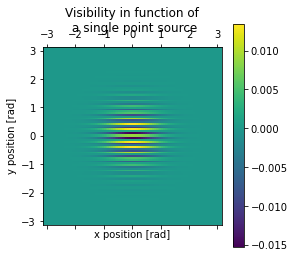

In [5]:
Nangle = 100
angle = np.linspace(-pi,pi,num=Nangle)

RES = []

for i in range(Nangle) :
    Rij = []
    for j in range(Nangle) :
        Tk = np.array([[angle[i],angle[j]]])
        Rij += [vij(Tk, sigma,S,beta,1.e8)[0]]
    RES += [Rij]

plt.matshow(RES,extent=[-pi,pi,-pi,pi])
plt.colorbar()
plt.xlabel('x position [rad]')
plt.ylabel('y position [rad]')
plt.title('Visibility in function of\n a single point source')

In [88]:
#compute derivatives 
def dvdx(x,y,sig1,sig2,S,beta,nu) :
    output = [0,0]

    Ai = np.exp(-0.5*(x**2+y**2)/sig1**2)/(sig1*np.sqrt(2*pi))
    Aj = np.exp(-0.5*(x**2+y**2)/sig2**2)/(sig2*np.sqrt(2*pi))

    res = Ai*Aj*S*(nu/nu_ref)**beta*np.exp(1j*2*pi*nu*(x*b[0] + y*b[1])/c) * (-x*(1/sig1**2  + 1/sig2**2) + 2j*pi*nu*b[0]/c)

    output[0] += res.real
    output[1] += res.imag
    
    return output
    
def dvdy(x,y,sig1,sig2,S,beta,nu) :
    output = [0,0]

    Ai = np.exp(-0.5*(x**2+y**2)/sig1**2)/(sig1*np.sqrt(2*pi))
    Aj = np.exp(-0.5*(x**2+y**2)/sig2**2)/(sig2*np.sqrt(2*pi))

    res = Ai*Aj*S*(nu/nu_ref)**beta*np.exp(1j*2*pi*nu*(x*b[0] + y*b[1])/c) * (-y*(1/sig1**2  + 1/sig2**2) + 2j*pi*nu*b[1]/c)

    output[0] += res.real
    output[1] += res.imag
        
    return output
      
def dvdsig1(x,y,sig1,sig2,S,beta,nu) :
    output = [0,0]

    Ai = np.exp(-0.5*(x**2+y**2)/sig1**2)/(sig1*np.sqrt(2*pi))
    Aj = np.exp(-0.5*(x**2+y**2)/sig2**2)/(sig2*np.sqrt(2*pi))

    res = Ai*Aj*S*(nu/nu_ref)**beta*np.exp(1j*2*pi*nu*(x*b[0] + y*b[1])/c) * (-1/sig1 + (1/sig1**3) *(x**2+y**2))

    output[0] += res.real
    output[1] += res.imag
        
    return output
    
def dvdsig2(x,y,sig1,sig2,S,beta,nu) :
    output = [0,0]

    Ai = np.exp(-0.5*(x**2+y**2)/sig1**2)/(sig1*np.sqrt(2*pi))
    Aj = np.exp(-0.5*(x**2+y**2)/sig2**2)/(sig2*np.sqrt(2*pi))

    res = Ai*Aj*S*(nu/nu_ref)**beta*np.exp(1j*2*pi*nu*(x*b[0] + y*b[1])/c) * (-1/sig2 + (1/sig2**3) *(x**2+y**2))

    output[0] += res.real
    output[1] += res.imag
        
    return output  
    
def dvdS(x,y,sig1,sig2,S,beta,nu) :
    output = [0,0]

    Ai = np.exp(-0.5*(x**2+y**2)/sig1**2)/(sig1*np.sqrt(2*pi))
    Aj = np.exp(-0.5*(x**2+y**2)/sig2**2)/(sig2*np.sqrt(2*pi))

    res = Ai*Aj*(nu/nu_ref)**beta*np.exp(1j*2*pi*nu*(x*b[0] + y*b[1])/c)

    output[0] += res.real
    output[1] += res.imag
        
    return output 

def dvdbeta(x,y,sig1,sig2,S,beta,nu) :
    output = [0,0]

    Ai = np.exp(-0.5*(x**2+y**2)/sig1**2)/(sig1*np.sqrt(2*pi))
    Aj = np.exp(-0.5*(x**2+y**2)/sig2**2)/(sig2*np.sqrt(2*pi))

    res = Ai*Aj*S*beta*(nu/nu_ref)**(beta-1.)*np.exp(1j*2*pi*nu*(x*b[0] + y*b[1])/c)

    output[0] += res.real
    output[1] += res.imag
        
    return output 

In [7]:
def logprob(x_params, fixed_params, data) :
    theta_1 = x_params[0]
    theta_2 = x_params[1]
    sigma_1 = x_params[2]
    sigma_2 = x_params[3]
    S_k = x_params[4]
    beta = x_params[5]
    
    
    theta = np.array([[theta_1, theta_2]])
    sigma = np.array([sigma_1,sigma_2])
    S = np.array([S_k])
    
    m = vij(theta, sigma, S, beta, fixed_params)
    
    logp =  -0.5*np.sum((m[0] - data[0])**2 + (m[1] - data[1])**2)

    grad = np.zeros(6)
    grad[0] = -1*np.sum(dvdx(theta_1,theta_2,sigma_1,sigma_2,S_k,beta,fixed_params)[0]*(m[0] - data[0]) + dvdx(theta_1,theta_2,sigma_1,sigma_2,S_k,beta,fixed_params)[1]*(m[1] - data[1])) 
    grad[1] = -1*np.sum(dvdy(theta_1,theta_2,sigma_1,sigma_2,S_k,beta,fixed_params)[0]*(m[0] - data[0]) + dvdy(theta_1,theta_2,sigma_1,sigma_2,S_k,beta,fixed_params)[1]*(m[1] - data[1])) 
    grad[2] = -1*np.sum(dvdsig1(theta_1,theta_2,sigma_1,sigma_2,S_k,beta,fixed_params)[0]*(m[0] - data[0]) + dvdsig1(theta_1,theta_2,sigma_1,sigma_2,S_k,beta,fixed_params)[1]*(m[1] - data[1])) 
    grad[3] = -1*np.sum(dvdsig2(theta_1,theta_2,sigma_1,sigma_2,S_k,beta,fixed_params)[0]*(m[0] - data[0]) + dvdsig2(theta_1,theta_2,sigma_1,sigma_2,S_k,beta,fixed_params)[1]*(m[1] - data[1])) 
    grad[4] = -1*np.sum(dvdS(theta_1,theta_2,sigma_1,sigma_2,S_k,beta,fixed_params)[0]*(m[0] - data[0]) + dvdS(theta_1,theta_2,sigma_1,sigma_2,S_k,beta,fixed_params)[1]*(m[1] - data[1])) 
    grad[5] = -1*np.sum(dvdbeta(theta_1,theta_2,sigma_1,sigma_2,S_k,beta,fixed_params)[0]*(m[0] - data[0]) + dvdbeta(theta_1,theta_2,sigma_1,sigma_2,S_k,beta,fixed_params)[1]*(m[1] - data[1])) 
    
    return logp, grad

In [8]:
#comparison : 

#x =  np.array([0.2,0.2,0.2,0.2,0.2,-2.])
#freqs = np.linspace(100.e6,120.e6,num=100)
#true_params = np.array([0.1,0.,0.1,0.103,0.103,-2.7])
#noises = 0.1*np.ones(6)
#data = vij(np.array([[0.1,0.]]),np.array([0.103,0.103]),np.array([0.1]),-2.7,freqs)

#test1, test2 = logprob(x,data)

# 1st coordinate of  theta

In [80]:
def logprob_unique_x(x,data) :
    m = vij(np.array([[x,0.]]), np.array([0.103,0.103]), np.array([0.1]), -2.7, np.linspace(100.e6,120.e6,num=100))
    logp =  - 0.5*np.sum((m[0] - data[0])**2 + (m[1] - data[1])**2) - 0.5*(x-0.1)**2/(0.1**2)
        
    grad = np.zeros(1)
    grad[0] = 1*np.sum(dvdx(x,0.,0.103,0.103,0.1,-2.7,np.linspace(100.e6,120.e6,num=100))[0]*(m[0] - data[0]) + dvdx(x,0.,0.103,0.103,0.1,-2.7,np.linspace(100.e6,120.e6,num=100))[1]*(m[1] - data[1])) - (x-0.1)/(0.1**2) 
    
    return logp, grad


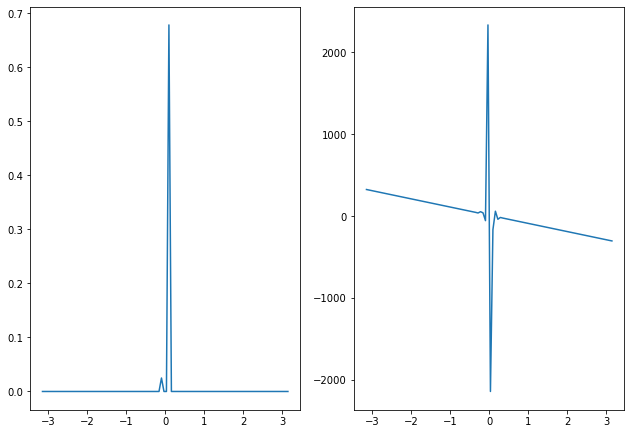

In [84]:
data = vij(np.array([[0.1,0]]), np.array([0.103,0.103]), np.array([0.1]), -2.7, np.linspace(100.e6,120.e6,num=100))

xs = np.linspace(-pi,pi,num=100)

ys = [np.exp(logprob_unique_x(x,data)[0]) for x in xs]
gys = [logprob_unique_x(x,data)[1] for x in xs]
#logprob_unique(,data)

plt.rcParams['figure.constrained_layout.use'] = False
plt.subplot(1,2,1)
plt.plot(xs,ys)
#plt.plot([0.1,0.1],[-150,10],'-k',linewidth=1)
plt.subplot(1,2,2)
plt.plot(xs,gys)
plt.subplots_adjust(bottom=0.1, right=1.5, top=1.5)

In [11]:
N_samples = 5000
N_params = 6


start = time.time()
samples = hmc(logprob_unique_x, x0=np.random.randn(1), args=([data]), n_samples=N_samples)
print('Time needed to compute HMC: '+ str(time.time()-start) + ' s')

Time needed to compute HMC: 6.556614398956299 s


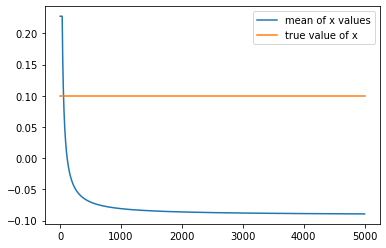

In [12]:
X = np.linspace(1,N_samples,num=N_samples)
for i in range(1) :
    T = samples[:,i]

    S = np.cumsum(T,0)
    M = [S[i]/(i+1) for i in range(len(S))]

    Ssq = np.cumsum(T**2,0)
    V = [Ssq[i]/(i+1) - S[i]/(i+1) for i in range(len(S))]
    plt.plot(X,M, label='mean of x values')

plt.plot([0.,N_samples],[0.1,0.1],label='true value of x')
plt.legend()

Text(0.5, 1.0, 'samples values')

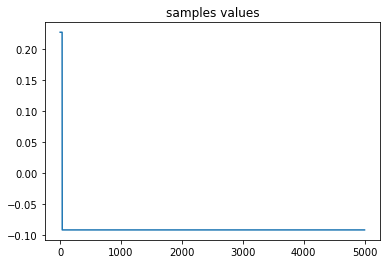

In [13]:
plt.plot(X,samples)
plt.title('samples values')

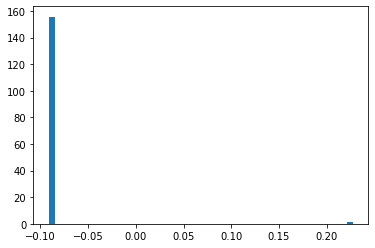

In [14]:
benne = plt.hist(samples,density=True,bins=50)

# 2nd coordinate of point source

In [15]:
def logprob_unique_y(x,data) :
    m = vij(np.array([[0.1,x]]), np.array([0.103,0.103]), np.array([0.1]), -2.7, np.linspace(100.e6,120.e6,num=100))
    logp =  - 0.5*np.sum((m[0] - data[0])**2 + (m[1] - data[1])**2) - 0.5*(x-0)**2/(0.1**2)
        
    grad = np.zeros(1)
    grad[0] = 1*np.sum(dvdy(0.1,x,0.103,0.103,0.1,-2.7,np.linspace(100.e6,120.e6,num=100))[0]*(m[0] - data[0]) + dvdx(0.1,x,0.103,0.103,0.1,-2.7,np.linspace(100.e6,120.e6,num=100))[1]*(m[1] - data[1])) - (x-0.)/(0.1**2) 
    
    return logp, grad


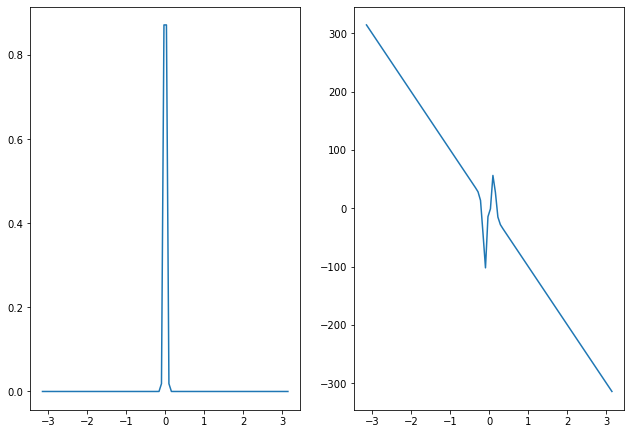

In [85]:
data = vij(np.array([[0.1,0.]]), np.array([0.103,0.103]), np.array([0.1]), -2.7, np.linspace(100.e6,120.e6,num=100))

xs = np.linspace(-pi,pi,num=100)

ys = [np.exp(logprob_unique_y(x,data)[0]) for x in xs]
gys = [logprob_unique_y(x,data)[1] for x in xs]
#logprob_unique(,data)

plt.rcParams['figure.constrained_layout.use'] = False
plt.subplot(1,2,1)
plt.plot(xs,ys)
plt.subplot(1,2,2)
plt.plot(xs,gys)
plt.subplots_adjust(bottom=0.1, right=1.5, top=1.5)

In [17]:
N_samples = 5000
N_params = 6


start = time.time()
samples = hmc(logprob_unique_y, x0=np.random.randn(1), args=([data]), n_samples=N_samples)
print('Time needed to compute HMC: '+ str(time.time()-start) + ' s')

Time needed to compute HMC: 6.39642333984375 s


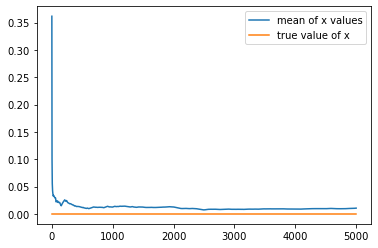

In [18]:
X = np.linspace(1,N_samples,num=N_samples)
for i in range(1) :
    T = samples[:,i]

    S = np.cumsum(T,0)
    M = [S[i]/(i+1) for i in range(len(S))]

    Ssq = np.cumsum(T**2,0)
    V = [Ssq[i]/(i+1) - S[i]/(i+1) for i in range(len(S))]
    plt.plot(X,M, label='mean of x values')

plt.plot([0.,N_samples],[0,0],label='true value of x')
plt.legend()

Text(0.5, 1.0, 'samples values')

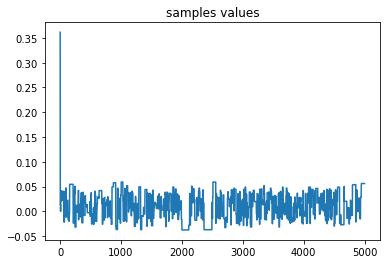

In [19]:
plt.plot(X,samples)
plt.title('samples values')

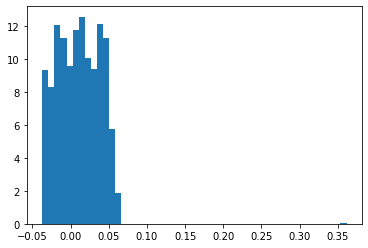

In [20]:
benne = plt.hist(samples,density=True,bins=50)

# 1st value of sigma

In [21]:
def logprob_unique_sig1(x,data) :
    m = vij(np.array([[0.1,0.]]), np.array([x,0.103]), np.array([0.1]), -2.7, np.linspace(100.e6,120.e6,num=100))
    logp =  - 0.5*np.sum((m[0] - data[0])**2 + (m[1] - data[1])**2) - 0.5*(x-0.103)**2/(0.01**2)
        
    grad = np.zeros(1)
    grad[0] = 1*np.sum(dvdsig1(0.1,0.,x,0.103,0.1,-2.7,np.linspace(100.e6,120.e6,num=100))[0]*(m[0] - data[0]) + dvdsig1(0.1,0.,x,0.103,0.1,-2.7,np.linspace(100.e6,120.e6,num=100))[1]*(m[1] - data[1])) - (x-0.103)/(0.01**2) 
    
    return logp, grad


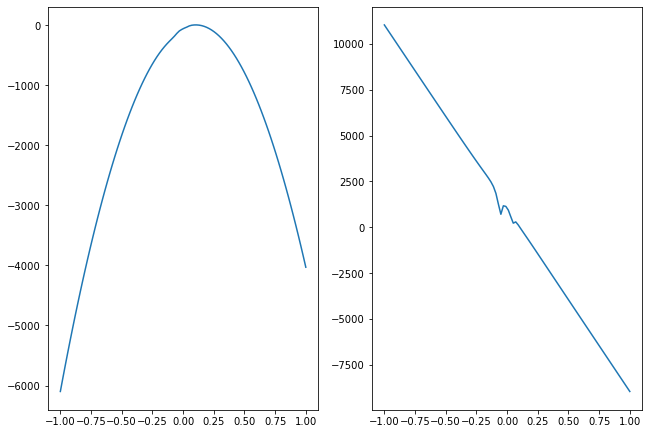

In [22]:
data = vij(np.array([[0.1,0.]]), np.array([0.103,0.103]), np.array([0.1]), -2.7, np.linspace(100.e6,120.e6,num=100))

xs = np.linspace(-1.,1.,num=100)

ys = [logprob_unique_sig1(x,data)[0] for x in xs]
gys = [logprob_unique_sig1(x,data)[1] for x in xs]
#logprob_unique(,data)

plt.rcParams['figure.constrained_layout.use'] = False
plt.subplot(1,2,1)
plt.plot(xs,ys)
plt.subplot(1,2,2)
plt.plot(xs,gys)
plt.subplots_adjust(bottom=0.1, right=1.5, top=1.5)

In [23]:
N_samples = 100000
N_params = 6


start = time.time()
samples = hmc(logprob_unique_sig1, x0=np.array([0.1]), args=([data]), n_samples=N_samples)
print('Time needed to compute HMC: '+ str(time.time()-start) + ' s')

Time needed to compute HMC: 118.36070108413696 s


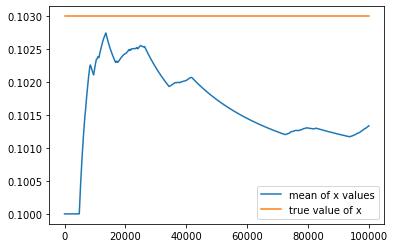

In [24]:
X = np.linspace(1,N_samples,num=N_samples)
for i in range(1) :
    T = samples[:,i]

    S = np.cumsum(T,0)
    M = [S[i]/(i+1) for i in range(len(S))]

    Ssq = np.cumsum(T**2,0)
    V = [Ssq[i]/(i+1) - S[i]/(i+1) for i in range(len(S))]
    plt.plot(X,M, label='mean of x values')

plt.plot([0.,N_samples],[0.103,0.103],label='true value of x')
plt.legend()

Text(0.5, 1.0, 'samples values')

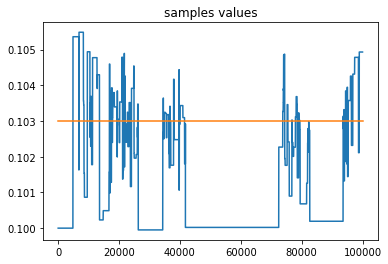

In [25]:
plt.plot(X,samples)
plt.plot([0.,N_samples],[0.103,0.103])

plt.title('samples values')

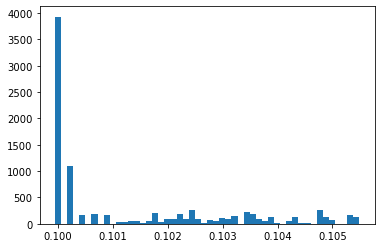

In [26]:
benne = plt.hist(samples,density=True,bins=50)

# 2nd value of sigma

In [27]:
def logprob_unique_sig2(x,data) :
    m = vij(np.array([[0.1,0.]]), np.array([0.103,x]), np.array([0.1]), -2.7, np.linspace(100.e6,120.e6,num=100))
    logp =  - 0.5*np.sum((m[0] - data[0])**2 + (m[1] - data[1])**2) - 0.5*(x-0.103)**2/(0.1**2)
        
    grad = np.zeros(1)
    grad[0] = 1*np.sum(dvdsig2(0.1,0.,0.103,x,0.1,-2.7,np.linspace(100.e6,120.e6,num=100))[0]*(m[0] - data[0]) + dvdsig2(0.1,0.,0.103,x,0.1,-2.7,np.linspace(100.e6,120.e6,num=100))[1]*(m[1] - data[1])) - (x-0.103)/(0.1**2) 
    
    return logp, grad


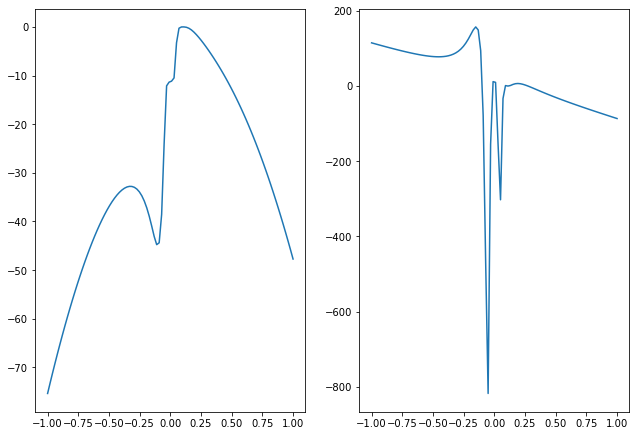

In [94]:
data = vij(np.array([[0.1,0.]]), np.array([0.103,0.103]), np.array([0.1]), -2.7, np.linspace(100.e6,120.e6,num=100))

xs = np.linspace(-1.,1.,num=100)

ys = [logprob_unique_sig2(x,data)[0] for x in xs]
gys = [logprob_unique_sig2(x,data)[1] for x in xs]
#logprob_unique(,data)

plt.rcParams['figure.constrained_layout.use'] = False
plt.subplot(1,2,1)
plt.plot(xs,ys)
plt.subplot(1,2,2)
plt.plot(xs,gys)
plt.subplots_adjust(bottom=0.1, right=1.5, top=1.5)

In [29]:
N_samples = 100000
N_params = 6


start = time.time()
samples = hmc(logprob_unique_sig2, x0=np.array([0.1]), args=([data]), n_samples=N_samples)
print('Time needed to compute HMC: '+ str(time.time()-start) + ' s')

Time needed to compute HMC: 117.36706328392029 s


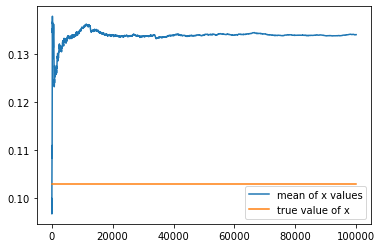

In [30]:
X = np.linspace(1,N_samples,num=N_samples)
for i in range(1) :
    T = samples[:,i]

    S = np.cumsum(T,0)
    M = [S[i]/(i+1) for i in range(len(S))]

    Ssq = np.cumsum(T**2,0)
    V = [Ssq[i]/(i+1) - S[i]/(i+1) for i in range(len(S))]
    plt.plot(X,M, label='mean of x values')

plt.plot([0.,N_samples],[0.103,0.103],label='true value of x')
plt.legend()

Text(0.5, 1.0, 'samples values')

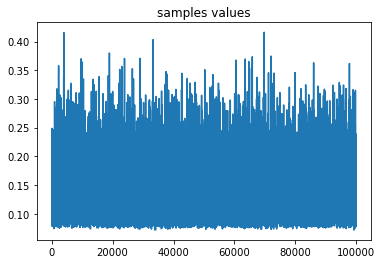

In [31]:
plt.plot(X,samples)
plt.title('samples values')

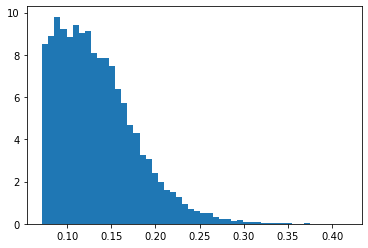

In [32]:
benne = plt.hist(samples,density=True,bins=50)


# Flux of the point source

In [33]:
def logprob_unique_S(x,data) :
    m = vij(np.array([[0.1,0.]]), np.array([0.103,0.103]), np.array([x]), -2.7, np.linspace(100.e6,120.e6,num=100))
    logp =  - 0.5*np.sum((m[0] - data[0])**2 + (m[1] - data[1])**2) - 0.5*(x-0.1)**2/(0.1**2)
        
    grad = np.zeros(1)
    grad[0] = -1*np.sum(dvdS(0.1,0.,0.103,0.103,x,-2.7,np.linspace(100.e6,120.e6,num=100))[0]*(m[0] - data[0]) + dvdS(0.1,0.,0.103,0.103,x,-2.7,np.linspace(100.e6,120.e6,num=100))[1]*(m[1] - data[1])) - (x-0.1)/(0.1**2) 
    
    return logp, grad

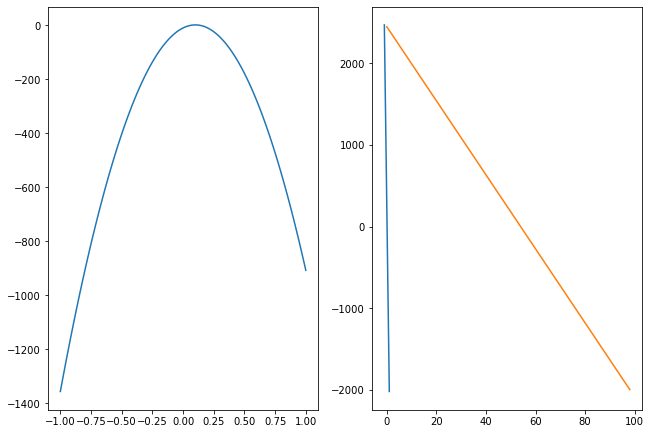

In [92]:
data = vij(np.array([[0.1,0]]), np.array([0.103,0.103]), np.array([0.1]), -2.7, np.linspace(100.e6,120.e6,num=100))

xs = np.linspace(-1.,1.,num=100)

ys = [logprob_unique_S(x,data)[0] for x in xs]
gys = [logprob_unique_S(x,data)[1] for x in xs]
#logprob_unique(,data)

plt.rcParams['figure.constrained_layout.use'] = False
plt.subplot(1,2,1)
plt.plot(xs,ys)
plt.subplot(1,2,2)
plt.plot(xs,gys)
plt.subplots_adjust(bottom=0.1, right=1.5, top=1.5)

In [35]:
N_samples = 100000
N_params = 6


start = time.time()
samples = hmc(logprob_unique_S, x0=[0.1], args=([data]), n_samples=N_samples)
print('Time needed to compute HMC: '+ str(time.time()-start) + ' s')

Time needed to compute HMC: 105.3661994934082 s


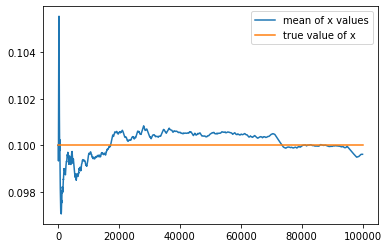

In [36]:
X = np.linspace(1,N_samples,num=N_samples)
for i in range(1) :
    T = samples[:,i]

    S = np.cumsum(T,0)
    M = [S[i]/(i+1) for i in range(len(S))]

    Ssq = np.cumsum(T**2,0)
    V = [Ssq[i]/(i+1) - S[i]/(i+1) for i in range(len(S))]
    plt.plot(X,M, label='mean of x values')

plt.plot([0.,N_samples],[0.1,0.1],label='true value of x')
plt.legend()

Text(0.5, 1.0, 'samples values')

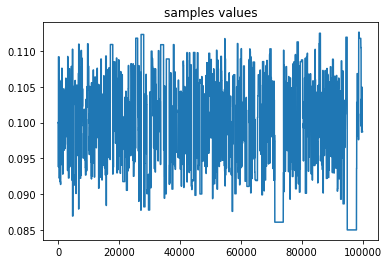

In [37]:
plt.plot(X,samples)
plt.title('samples values')

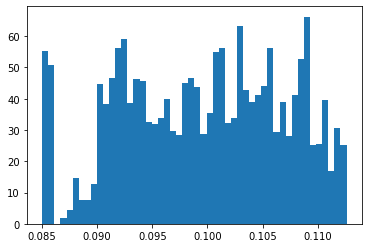

In [38]:
benne = plt.hist(samples,density=True,bins=50)

# Beta

In [39]:
def logprob_unique_beta(x,data) :
    m = vij(np.array([[0.1,0.]]), np.array([0.103,0.103]), np.array([0.1]), x, np.linspace(100.e6,120.e6,num=100))
    logp =  - 0.5*np.sum((m[0] - data[0])**2 + (m[1] - data[1])**2) - 0.5*(x+2.7)**2/(0.1**2)
        
    grad = np.zeros(1)
    grad[0] = -1*np.sum(dvdbeta(0.1,0.,0.103,0.103,0.1,x,np.linspace(100.e6,120.e6,num=100))[0]*(m[0] - data[0]) + dvdbeta(0.1,0.,0.103,0.103,0.1,x,np.linspace(100.e6,120.e6,num=100))[1]*(m[1] - data[1])) - (x+2.7)/(0.1**2) 
    
    return logp, grad

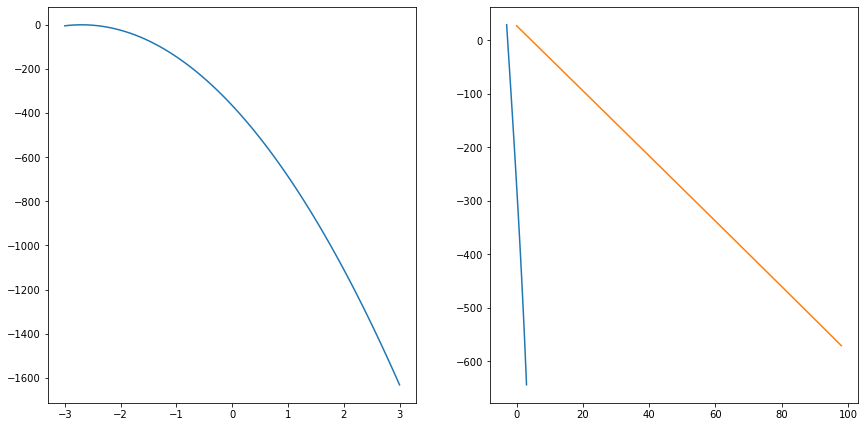

In [91]:
data = vij(np.array([[0.1,0]]), np.array([0.103,0.103]), np.array([0.1]), -2.7, np.linspace(100.e6,120.e6,num=100))

xs = np.linspace(-3.,3.,num=100)

ys = [logprob_unique_beta(x,data)[0] for x in xs]
gys = [logprob_unique_beta(x,data)[1] for x in xs]
#logprob_unique(,data)

plt.rcParams['figure.constrained_layout.use'] = False
plt.subplot(1,2,1)
plt.plot(xs,ys)
plt.subplot(1,2,2)
plt.plot(xs,gys)
plt.subplots_adjust(right=2, top=1.5)

In [41]:
N_samples = 1000

start = time.time()
samples = hmc(logprob_unique_beta, x0=np.random.randn(1), args=([data]), n_samples=N_samples)
print('Time needed to compute HMC: '+ str(time.time()-start) + ' s')

Time needed to compute HMC: 1.1373136043548584 s


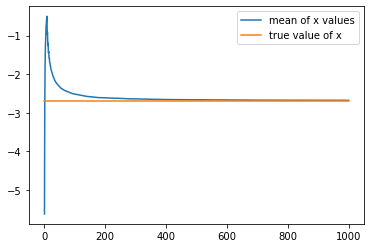

In [42]:
X = np.linspace(1,N_samples,num=N_samples)
for i in range(1) :
    T = samples[:,i]

    S = np.cumsum(T,0)
    M = [S[i]/(i+1) for i in range(len(S))]

    Ssq = np.cumsum(T**2,0)
    V = [Ssq[i]/(i+1) - S[i]/(i+1) for i in range(len(S))]
    plt.plot(X,M, label='mean of x values')

plt.plot([0.,N_samples],[-2.7,-2.7],label='true value of x')
plt.legend()

Text(0.5, 1.0, 'samples values')

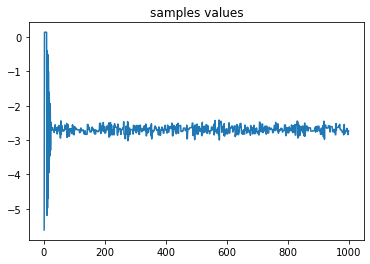

In [43]:
plt.plot(X,samples)
plt.title('samples values')

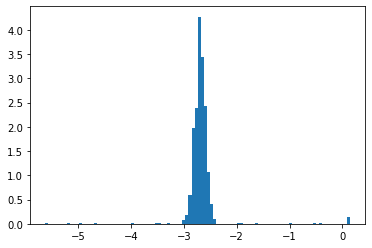

In [44]:
benne = plt.hist(samples,density=True,bins=100)

# All the parameters at the same time without prior

In [45]:
def logprob(x,data) :
    m = vij(np.array([[x[0],x[1]]]), np.array([x[2],x[3]]), np.array([x[4]]), x[5], np.linspace(100.e6,120.e6,num=100))
    
    logp =  -0.5*np.sum((m[0] - data[0])**2 + (m[1] - data[1])**2)

    grad = np.zeros(6)
    grad[0] = -1*np.sum(dvdx(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[0]*(m[0] - data[0]) + dvdx(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[1]*(m[1] - data[1])) 
    grad[1] = -1*np.sum(dvdy(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[0]*(m[0] - data[0]) + dvdy(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[1]*(m[1] - data[1])) 
    grad[2] = -1*np.sum(dvdsig1(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[0]*(m[0] - data[0]) + dvdsig1(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[1]*(m[1] - data[1])) 
    grad[3] = -1*np.sum(dvdsig2(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[0]*(m[0] - data[0]) + dvdsig2(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[1]*(m[1] - data[1])) 
    grad[4] = -1*np.sum(dvdS(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[0]*(m[0] - data[0]) + dvdS(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[1]*(m[1] - data[1])) 
    grad[5] = -1*np.sum(dvdbeta(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[0]*(m[0] - data[0]) + dvdbeta(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[1]*(m[1] - data[1])) 
    
    return logp, grad

In [46]:
N_samples = 100000

start = time.time()
samples = hmc(logprob, x0=np.random.randn(6), args=([data]), n_samples=N_samples)
print('Time needed to compute HMC: '+ str(time.time()-start) + ' s')

Time needed to compute HMC: 422.29205775260925 s


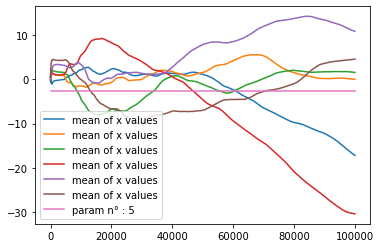

In [47]:
X = np.linspace(1,N_samples,num=N_samples)
for i in range(6) :
    T = samples[:,i]

    S = np.cumsum(T,0)
    M = [S[i]/(i+1) for i in range(len(S))]

    Ssq = np.cumsum(T**2,0)
    V = [Ssq[i]/(i+1) - S[i]/(i+1) for i in range(len(S))]
    plt.plot(X,M, label='mean of x values')

plt.plot([0.,N_samples],[-2.7,-2.7],label='param n° : '+str(i))
plt.legend()

# All the parameters at the same time with prior => log posterior

In [48]:
noise_prior = 0.1

def logprob(x,data) :
    m = vij(np.array([[x[0],x[1]]]), np.array([x[2],x[3]]), np.array([x[4]]), x[5], np.linspace(100.e6,120.e6,num=100))
    
    logp =  -0.5*np.sum((m[0] - data[0])**2 + (m[1] - data[1])**2) - 0.5*(x[0] - 0.1)**2/(noise_prior**2)  - 0.5*(x[1] - 0.)**2/(noise_prior**2)  - 0.5*(x[2] - 0.103)**2/(noise_prior**2)  - 0.5*(x[3] - 0.103)**2/(noise_prior**2)  - 0.5*(x[4] - 0.1)**2/(noise_prior**2) - 0.5*(x[5] + 2.7)**2/(noise_prior**2)

    grad = np.zeros(6)
    grad[0] = -1*np.sum(dvdx(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[0]*(m[0] - data[0]) + dvdx(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[1]*(m[1] - data[1])) - (x[0]-0.1)/(noise_prior**2)
    grad[1] = -1*np.sum(dvdy(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[0]*(m[0] - data[0]) + dvdy(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[1]*(m[1] - data[1])) - (x[1]-0.)/(noise_prior**2)
    grad[2] = -1*np.sum(dvdsig1(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[0]*(m[0] - data[0]) + dvdsig1(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[1]*(m[1] - data[1])) - (x[2]-0.103)/(noise_prior**2)
    grad[3] = -1*np.sum(dvdsig2(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[0]*(m[0] - data[0]) + dvdsig2(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[1]*(m[1] - data[1])) - (x[3]-0.103)/(noise_prior**2)
    grad[4] = -1*np.sum(dvdS(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[0]*(m[0] - data[0]) + dvdS(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[1]*(m[1] - data[1])) - (x[4]-0.1)/(noise_prior**2)
    grad[5] = -1*np.sum(dvdbeta(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[0]*(m[0] - data[0]) + dvdbeta(x[0], x[1], x[2], x[3], x[4], x[5], np.linspace(100.e6,120.e6,num=100))[1]*(m[1] - data[1])) - (x[5]+2.7)/(noise_prior**2)
    
    return logp, grad

In [49]:
N_samples = 100

start = time.time()
samples = hmc(logprob, x0=np.random.randn(6), args=([data]), n_samples=N_samples)
print('Time needed to compute HMC: '+ str(time.time()-start) + ' s')

Time needed to compute HMC: 0.4677314758300781 s


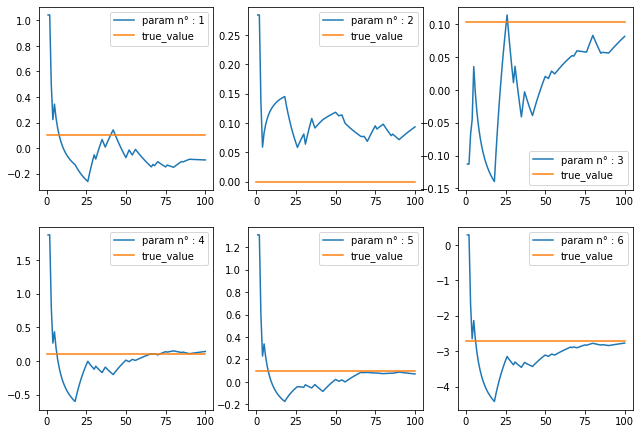

In [50]:
X = np.linspace(1,N_samples,num=N_samples)
for i in range(5) :
    T = samples[:,i]

    S = np.cumsum(T,0)
    M = [S[i]/(i+1) for i in range(len(S))]

    Ssq = np.cumsum(T**2,0)
    V = [Ssq[i]/(i+1) - S[i]/(i+1) for i in range(len(S))]
    plt.plot(X,M, label='param n° : '+str(i+1))

plt.legend()


plt.rcParams['figure.constrained_layout.use'] = False
true = [0.1,0.,0.103,0.103,0.1,-2.7]
for i in range(6) :
    T = samples[:,i]

    S = np.cumsum(T,0)
    M = [S[i]/(i+1) for i in range(len(S))]

    Ssq = np.cumsum(T**2,0)
    V = [Ssq[i]/(i+1) - S[i]/(i+1) for i in range(len(S))]
    
    plt.subplot(2,3,i+1)
    plt.plot(X,M, label='param n° : '+str(i+1))
    plt.plot([0.,N_samples],[true[i],true[i]], label='true_value')
    plt.legend()

plt.subplots_adjust(bottom=0.1, right=1.5, top=1.5)

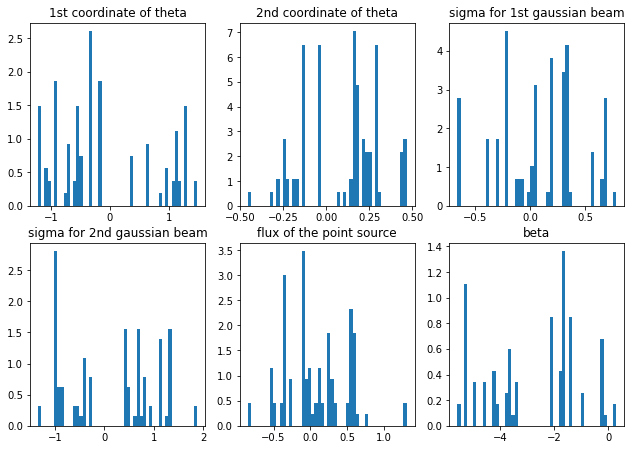

In [51]:
plt.rcParams['figure.constrained_layout.use'] = False
plt.subplot(2,3,1)
plt.title('1st coordinate of theta')
benne = plt.hist(samples[:,0], bins=50, density=True)
plt.subplot(2,3,2) 
plt.title('2nd coordinate of theta')
benne = plt.hist(samples[:,1], bins=50, density=True)
plt.subplot(2,3,3)
plt.title('sigma for 1st gaussian beam')
benne = plt.hist(samples[:,2], bins=50, density=True)
plt.subplot(2,3,4)
plt.title('sigma for 2nd gaussian beam')
benne = plt.hist(samples[:,3], bins=50, density=True)
plt.subplot(2,3,5)
plt.title('flux of the point source')
benne = plt.hist(samples[:,4], bins=50, density=True)
plt.subplot(2,3,6)
plt.title('beta')
benne = plt.hist(samples[:,5], bins=50, density=True)

plt.subplots_adjust(bottom=0.1, right=1.5, top=1.5)

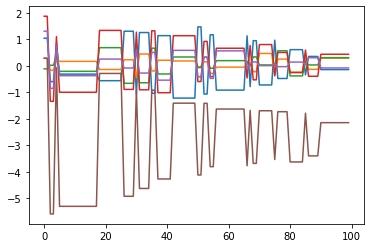

In [52]:
for i in range(6) :
    plt.plot(samples[:,i])


In [53]:
test1,test2 = logprob(np.array([0.2,0.2,0.2,0.2,0.2,-2.]), data)

In [54]:
test1

-43.6151701837671

In [55]:
test2

array([ 63.98752731,  28.62927476, -34.01463738, -34.01463738,
       -34.31463738, -61.00481508])

# Comparison between $Vij$ and visCPU

In [56]:
from hera_sim.visibilities import VisCPU#, HealVis#, VisGPU#, PRISim
from hera_sim import io
import numpy as np
import healpy
import matplotlib.pyplot as plt
import itertools
import copy
from pyuvsim.analyticbeam import AnalyticBeam
from pyuvdata import UVBeam
import uvtools

HERA_coord = [-30.72146*pi/180, 21.42822*pi/180] 

dist = 14.6
ants = {}

for i in range(0, 2):
        ants.update([(i, (-1.*dist/2 + i*14.6,0., 0.))])   

/home/hera/.local/lib/python3.7/site-packages/hera_sim-0.3.0-py3.7.egg/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/home/hera/.local/lib/python3.7/site-packages/hera_sim-0.3.0-py3.7.egg/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/home/hera/.local/lib/python3.7/site-packages/hera_sim-0.3.0-py3.7.egg/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/home/hera/.local/lib/python3.7/site-packages/hera_sim-0.3.0-py3.7.egg/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Ad

Text(0, 0.5, 'y in metre')

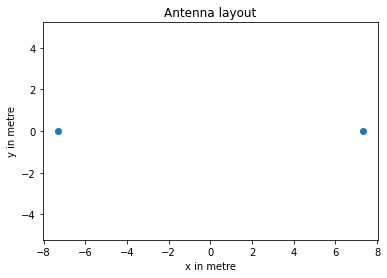

In [57]:
Nant = len(ants)
ant_index = list(ants.keys())

antscord = list(ants.values())[:]
antscord = np.array(antscord)

plt.scatter(antscord[:,0],antscord[:,1])
plt.axis('equal')
plt.title('Antenna layout')
plt.xlabel('x in metre')
plt.ylabel('y in metre')

In [58]:
def myuvdata(ntimes=160, **kwargs): #160
    return io.empty_uvdata(
        nfreq = nfreqs,
        start_freq = 1.e8,
        channel_width = 0.2e8 / nfreqs,
        start_time=2458902.4,
        integration_time = 40.,
        ntimes= ntimes,
        ants = ants,
        **kwargs
    )

beam = [AnalyticBeam("gaussian", sigma=1.) for i in range(Nant)]

In [59]:
Nangle = 50
angle = np.linspace(-pi,pi,num=Nangle)
freqs = np.array([1.000e+08])
nfreqs = 1
RES = []
flux = np.array([[0.1]])

for i in range(Nangle) :
    Rij = []
    for j in range(Nangle) :
        Tk = np.array([[angle[i],angle[j]]])
        
        uvdata = myuvdata(1)
        
        simulator = VisCPU(
            uvdata = uvdata,
            beams = beam,
            beam_ids = ant_index,
            sky_freqs = freqs,
            point_source_pos = Tk,
            point_source_flux = flux,
            bm_pix = 20
        )
        simulator.simulate()
        visibility = simulator.uvdata.get_data(0,1)
        vij_real = np.float(visibility[0].real)
        
        
        Rij += [vij_real]
    RES += [Rij]

invalid value encountered in sqrt


Text(0.5, 1.05, 'Visibility in function of\n a single point source')

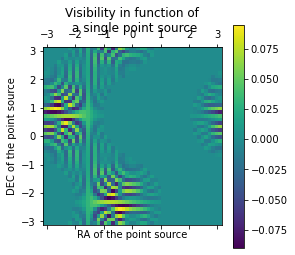

In [60]:
plt.matshow(RES, extent=[-pi,pi,-pi,pi])
plt.colorbar()
plt.xlabel('RA of the point source')
plt.ylabel('DEC of the point source')
plt.title('Visibility in function of\n a single point source')

In [61]:
truc = [my_vij(0.1, 0., 0.103, 0.103, 0.1, beta, freq) for freq in freqs]
test = [my_vij_grad(0.1, 0., 0.103, 0.103, 0.1, beta, freq) for freq in freqs]
#test = my_vij_grad(0.1, 0., 0.103, 0.103, 0.1, beta, 100.)
plt.plot(freqs, np.real(truc))
plt.plot(freqs, np.real(test))

NameError: name 'my_vij' is not defined

In [ ]:
x_params = np.array([0.1, 0., 0.103, 0.103, 0.1, beta])
fixed_params = np.linspace(100.,120.,num=Nfreq)*1e6 
data = my_vij(0.1, 0., 0.103, 0.103, 0.1, beta, fixed_params)
data_bar = my_vij_bar(0.1, 0., 0.103, 0.103, 0.1, beta, fixed_params)

In [ ]:
def my_vij_real(t1,t2,sig1,sig2,S,beta,nu) :
    Ai = np.exp(-0.5*(t1**2+t2**2)/sig1**2) / (sig1*np.sqrt(2*pi))
    Aj = np.exp(-0.5*(t1**2+t2**2)/sig2**2) / (sig1*np.sqrt(2*pi))
    return np.real((Ai*Aj*S*(nu/nu_ref)**beta*np.exp(-1j*2*pi*t1*nu/c)))

def my_vij_imag(t1,t2,sig1,sig2,S,beta,nu) :
    Ai = np.exp(-0.5*(t1**2+t2**2)/sig1**2) / (sig1*np.sqrt(2*pi))
    Aj = np.exp(-0.5*(t1**2+t2**2)/sig2**2) / (sig1*np.sqrt(2*pi))
    return np.imag((Ai*Aj*S*(nu/nu_ref)**beta*np.exp(-1j*2*pi*t1*nu/c)))

def my_vij(t1,t2,sig1,sig2,S,beta,nu) :
    return my_vij_real(t1,t2,sig1,sig2,S,beta,nu) + 1j*my_vij_imag(t1,t2,sig1,sig2,S,beta,nu)

def my_vij_bar(t1,t2,sig1,sig2,S,beta,nu) :
    return my_vij_real(t1,t2,sig1,sig2,S,beta,nu) - 1j*my_vij_imag(t1,t2,sig1,sig2,S,beta,nu)

def my_vij_grad(t1,t2,sig1,sig2,S,beta,nu) :
    func_real = autograd.jacobian(my_vij_real)
    func_imag = autograd.jacobian(my_vij_imag)
    print(func_imag)
    return func_real(t1,t2,sig1,sig2,S,beta,nu) + 1j * func_imag(t1,t2,sig1,sig2,S,beta,nu)

def my_vij_grad_bar(t1,t2,sig1,sig2,S,beta,nu) :
    func_real = autograd.jacobian(my_vij_real)
    func_imag = autograd.jacobian(my_vij_imag)
    return func_real(t1,t2,sig1,sig2,S,beta,nu) - 1j * func_imag(t1,t2,sig1,sig2,S,beta,nu)

def logprob(x_params, fixed_params, data, data_bar) :
    theta_1 = x_params[0]
    theta_2 = x_params[1]
    sigma_1 = x_params[2]
    sigma_2 = x_params[3]
    S_k = x_params[4]
    beta = x_params[5]
    
    theta = np.array([[theta_1, theta_2]])
    sigma = np.array([sigma_1,sigma_2])
    S = np.array([S_k])
    
    m = my_vij(theta_1, theta_2, sigma_1, sigma_2, S_k, beta, fixed_params)
    m_bar = my_vij_bar(theta_1, theta_2, sigma_1, sigma_2, S_k, beta, fixed_params)
    
    logp =  -0.5*np.sum((m - data)*(m_bar-data_bar)).real
    
        
    #grad = -0.5*np.sum( my_vij_grad(theta_1, theta_2, sigma_1, sigma_2, S_k, beta, fixed_params)*(m_bar - data_bar) + (m - data)* my_vij_grad_bar(theta_1, theta_2, sigma_1, sigma_2, S_k, beta, fixed_params)).real
    
    
    
    
    
    return logp, grad

